In [1]:
import os
print(os.getcwd())

/


In [2]:
import sys
sys.path.append('/mmpatil/MEA_Analysis_FEB25/IPNAnalysis/StimAnalysis')
from StimAnalysis import StimulationAnalysis

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as sp
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as qm
#import helper_functions as helper

In [123]:
#Reading the file, BP filtering
local_path= '/mnt/disk20tb/PrimaryNeuronData/Maxtwo/Stimulation_MaxOnePlus_MP/250423/P002820/Trace_20250423_16_49_17.raw.h5' #network data from chip 16848

recording1 = se.read_maxwell(local_path)
freq_min = 300
freq_max = 4500


#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()


#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=freq_min, freq_max=freq_max)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=900*fs)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")


Sampling frequency: 20000.0
Number of channels: 529
Number of segments: 1
total_recording: 906.06 s
chunk duration: 900.0 s


In [124]:
# Extract channel IDs and 2D location coordinates
channel_ids =np.array([int(x) for x in recording_chunk.get_channel_ids()])
locs = recording_chunk.get_channel_locations()
channels_to_highlight = [38]# Channels to highlight



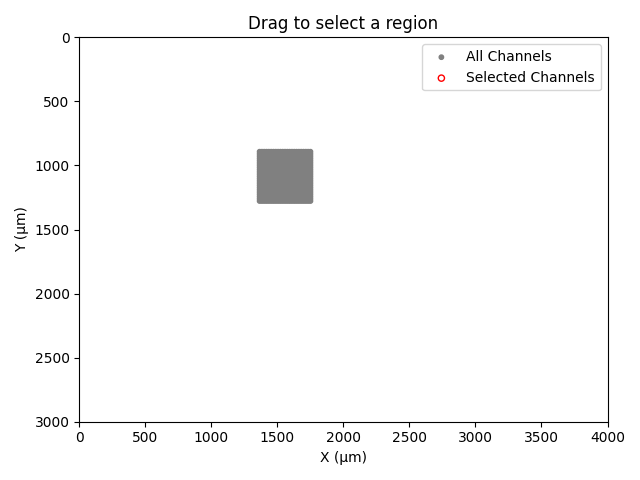

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets
from IPython.display import display
import os

# Enable interactive matplotlib
%matplotlib widget
# plt.flush() is not a valid method and has been removed
# Setup figure
fig, ax = plt.subplots()
c = ['gray'] * len(channel_ids)  # Default color for all channels
if channels_to_highlight is not None:
    for ch in channels_to_highlight: 
        if ch in channel_ids:
            idx = np.where(channel_ids == ch)[0][0]
            c[idx] = 'blue'  # Highlight specified channels in red   

sc = ax.scatter(locs[:, 0], locs[:, 1], c=c, label='All Channels', s=10)
ax.set_title("Drag to select a region")
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)")


# Scatter for selected points
selected_plot = ax.scatter([], [], facecolors='none', edgecolors='red', linewidths=1, s=20, label='Selected Channels')
selected_channels = []

# Create an output widget for displaying messages
output = widgets.Output()

# Selection callback with cumulative selection
def onselect(eclick, erelease):
    global selected_channels
    if eclick.xdata is None or erelease.xdata is None:  # Ignore clicks outside the plot
        return

    x0, y0 = eclick.xdata, eclick.ydata
    x1, y1 = erelease.xdata, erelease.ydata

    mask = (
        (locs[:, 0] > min(x0, x1)) & (locs[:, 0] < max(x0, x1)) &
        (locs[:, 1] > min(y0, y1)) & (locs[:, 1] < max(y0, y1))
    )
    new_selection = channel_ids[mask]

    # Check if Ctrl key is pressed (use event modifiers)
    if eclick.key == 'control':  # Append to existing selection
        selected_channels = np.unique(np.concatenate((selected_channels, new_selection)))
    else:  # Overwrite selection
        selected_channels = new_selection

    selected_plot.set_offsets(locs[np.isin(channel_ids, selected_channels)])
    fig.canvas.draw_idle()

    # Display the selection details in the output widget
    with output:
        output.clear_output()  # Clear previous messages
        print(f"🔴 Selected {len(selected_channels)} channels")
        print(selected_channels)

# Create RectangleSelector
selector = RectangleSelector(
    ax, onselect,
    interactive=True,
    useblit=True,
    button=[1]
)

# Create save button
save_button = widgets.Button(
    description="💾 Save Selected Channels",
    button_style='success',
    tooltip='Save selected channel IDs to file'
)

# Define callback to save to file
def save_selected_channels_to_file(b):
    if len(selected_channels) == 0:
        with output:
            output.clear_output()
            print("No channels selected to save.")
        return

    save_path = "selected_channels.txt"
    with open(save_path, "w") as f:
        f.write(",".join(map(lambda ch: f'"{ch}"', selected_channels)))

    with output:
        output.clear_output()
        print(f"Saved {len(selected_channels)} channel IDs to {os.path.abspath(save_path)}")

# Attach callback and show button
save_button.on_click(save_selected_channels_to_file)

# Display the save button and output widget
display(widgets.VBox([save_button, output]))
plt.xlim([0,4000])
plt.ylim([0,3000])
plt.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [7]:
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
import importlib
# Reload the spikeinterface.widgets module
importlib.reload(sw)
%matplotlib widget
# Visualize the traces interactively
print("Visualizing traces interactively...")
channel_ids = ["100", "820"]
sw.plot_timeseries(recording_chunk, channel_ids=channel_ids, mode='line', show_channel_ids=True, backend='ipywidgets')

Visualizing traces interactively...


/home/miniconda3/lib/python3.8/site-packages/spikeinterface/widgets/widget_list.py:148: UserWarning: plot_timeseries() is now plot_traces()
  warnings.warn("plot_timeseries() is now plot_traces()")


AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [55]:
import spikeinterface.preprocessing as spp
import spikeinterface.extractors as se

# Step 1: Scale the recording (applies gain/offset so output is in µV)
recording_scaled = spp.scale(recording_chunk)

# Step 2: Save the scaled recording as binary (.raw + .json)
se.BinaryRecordingExtractor.write_recording(
    recording=recording_scaled,
    file_paths='/mmpatil/MEA_Analysis_FEB25/IPNAnalysis/StimAnalysis/saved_mmap',
    dtype='float32',  # Saves scaled data in float32
    progress_bar=True,
    n_jobs=32
)

In [56]:
# Step 3: Load mmap recording
recording_mmap = se.BinaryRecordingExtractor( file_paths='/mmpatil/MEA_Analysis_FEB25/IPNAnalysis/StimAnalysis/saved_mmap..raw',
    sampling_frequency=recording_chunk.get_sampling_frequency(),
    num_channels=recording_chunk.get_num_channels(),
    dtype='float32',  # must match what you saved
    channel_ids=recording_chunk.get_channel_ids() )



In [58]:

fs = recording_mmap.get_sampling_frequency()
start_frame = int(300 * fs)
end_frame = int(600 * fs)

recording_slice = recording_mmap.frame_slice(start_frame, end_frame)

In [73]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spp
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

from spikeinterface.core.recording_tools import get_noise_levels

import numpy as np

# Construct custom absolute thresholds: 18 µV for each channel
num_channels = recording_chunk.get_num_channels()
manual_abs_thresholds = np.full(num_channels, 1)  # µV

# Now run detect_peaks with custom noise levels
peaks2 = detect_peaks(
    recording=recording_slice,
    method='by_channel',
    peak_sign='neg',
    detect_threshold=10,         # k = 1 → just use manual_abs_thresholds
    noise_levels=manual_abs_thresholds,  # These are already in µV     the data is 
    chunk_duration='300s',
    n_jobs=32,
    progress_bar=True
)

"""
A noise level of 0.00 µV will break the logic of peak detection using k × MAD, because:

Any finite value of detect_threshold × noise becomes zero, and every downward blip becomes a “detected spike”.
"""

'\nA noise level of 0.00 µV will break the logic of peak detection using k × MAD, because:\n\nAny finite value of detect_threshold × noise becomes zero, and every downward blip becomes a “detected spike”.\n'

In [71]:
peaks2

array([(     28,  37, -23., 0), (     28,  57,  -7., 0),
       (     28, 300, -26., 0), ..., (5999931,  19,  -6., 0),
       (5999955,  19,  -6., 0), (5999978,  19,  -9., 0)],
      dtype=[('sample_index', '<i8'), ('channel_index', '<i8'), ('amplitude', '<f8'), ('segment_index', '<i8')])

In [66]:
# Get scaled noise levels (in µV)
noise_levels = get_noise_levels(recording_chunk, return_scaled=True)
print(noise_levels.shape)
# Optional: Print estimated noise level for Channel 88
channel_idx = np.where(recording_chunk.get_channel_ids() == "88")[0][0]
print(f"Noise level on Channel 88 = {noise_levels[channel_idx]:.2f} µV")

(529,)
Noise level on Channel 88 = 0.00 µV


[]


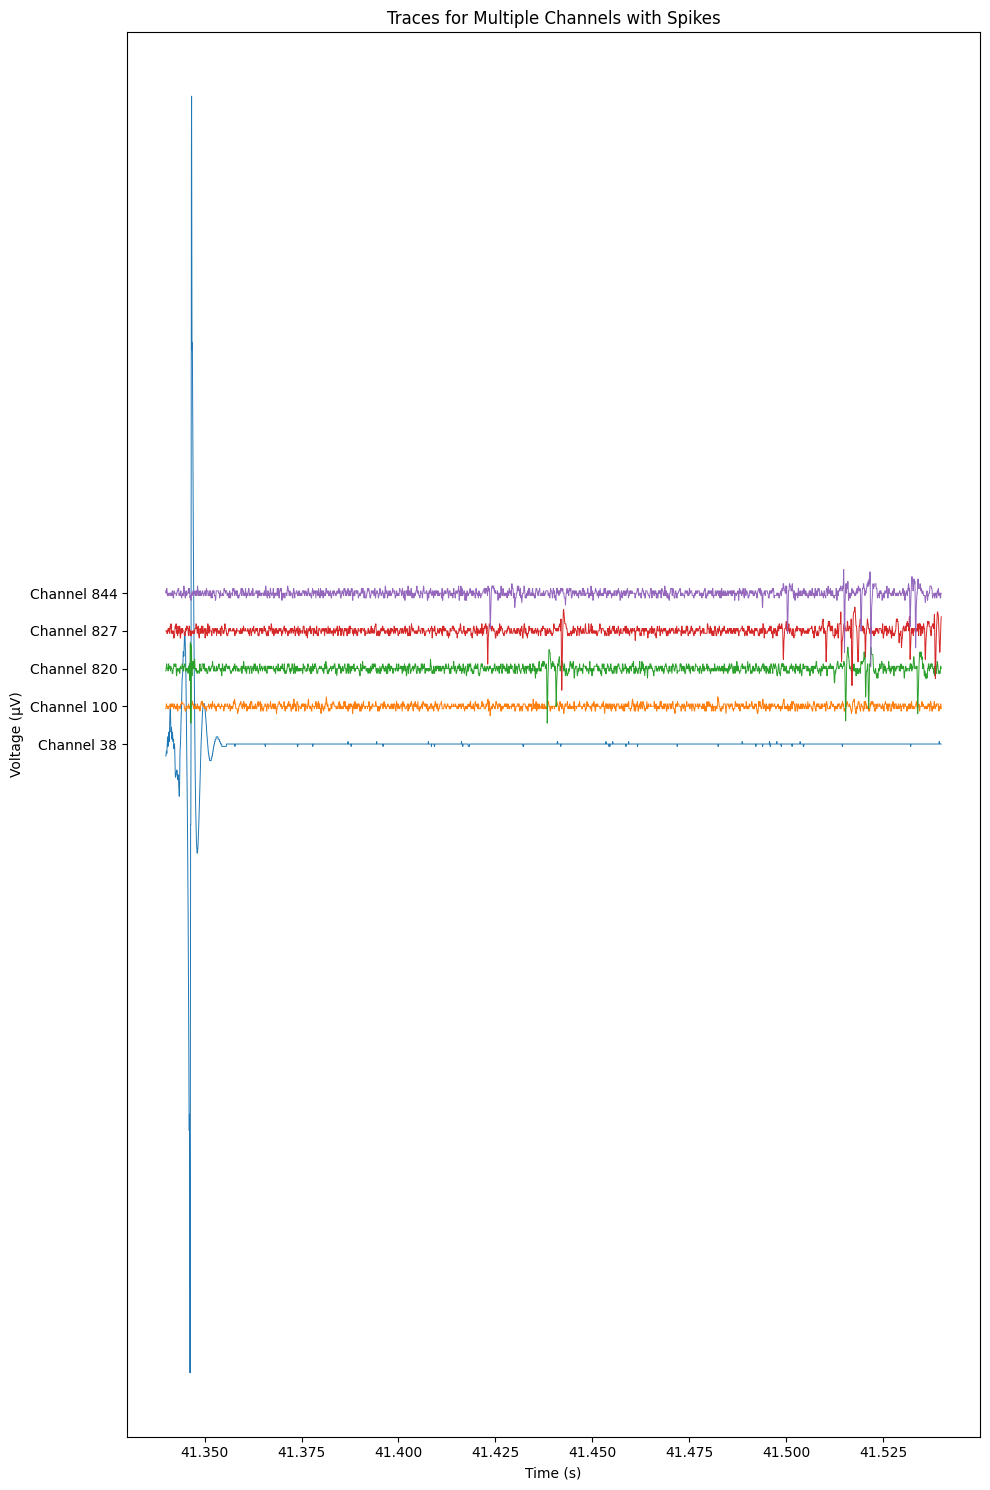

In [156]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# --- Parameters ---
channels = ["38","100","820","827","844"]  # List of channel IDs as strings
start_time = 41.34
end_time = 41.54
fs = recording_chunk.get_sampling_frequency()
rec_var = recording_chunk.frame_slice(start_frame=int(300 * fs), end_frame=int(600 * fs))

# --- Extract traces and spike data for each channel ---
plt.close('all')
plt.figure(figsize=(10, len(channels) * 3))  # Adjust figure height dynamically
offset = 100  # Offset for separating traces visually
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store channel names for labeling

for i, channel in enumerate(channels):
    channel_int = int(channel)  # Convert to int for comparison

    # Extract trace
    start_frame = int(start_time * fs)
    end_frame = int(end_time * fs)
    trace = rec_var.get_traces(
        start_frame=start_frame,
        end_frame=end_frame,
        channel_ids=[channel],
        return_scaled=True
    ).flatten()

    # Time axis
    time_axis = np.arange(len(trace)) / fs + start_time

    # Extract spike times for this channel in time window
    channel_idx = np.where(recording_chunk.get_channel_ids() == channel)[0][0]  # Get the integer index of the channel
    channel_peaks = peaks2[peaks2['channel_index'] == channel_idx]
    spike_samples = channel_peaks['sample_index']

    # Keep spikes only within current time window
    mask = (spike_samples >= start_frame) & (spike_samples <= end_frame)
    spike_times_window = spike_samples[mask]
    spike_sample_indices = spike_times_window - start_frame
    spike_amplitudes = trace[spike_sample_indices]

    # Plot trace and spikes
    plt.plot(
        time_axis,
        trace + i * offset,  # Offset for visual separation
        linewidth=0.7,
        label=f"Trace (Channel {channel})"
    )
    if channel =="38" : print(spike_sample_indices)
    # plt.plot(
    #     time_axis[spike_sample_indices],
    #     spike_amplitudes + i * offset,
    #     'rv',
    #     markersize=6,
    #     label=f"Spikes (Channel {channel})"
    # )

    # Add y-axis tick position and label
    yticks_positions.append(i * offset)
    yticks_labels.append(f"Channel {channel}")

# --- Customize plot ---
plt.xlabel("Time (s)")
plt.ylabel("Voltage (µV)")
plt.title("Traces for Multiple Channels with Spikes")
#plt.grid(True)
#plt.legend()
plt.yticks(yticks_positions, yticks_labels)
plt.tight_layout()
plt.savefig("traces_with_spikes.svg", dpi=300,format='svg')
plt.show()

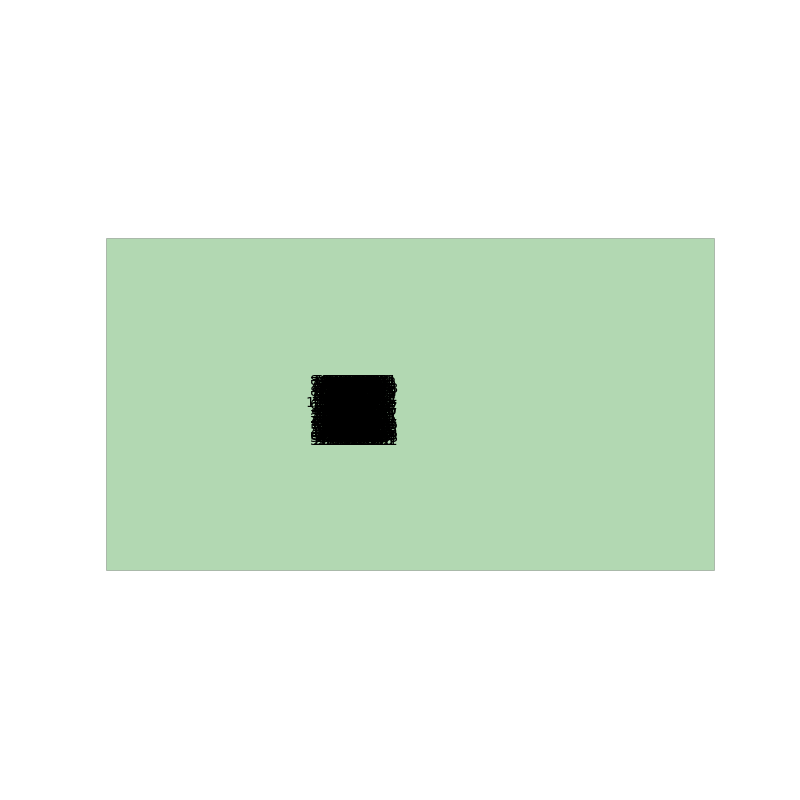

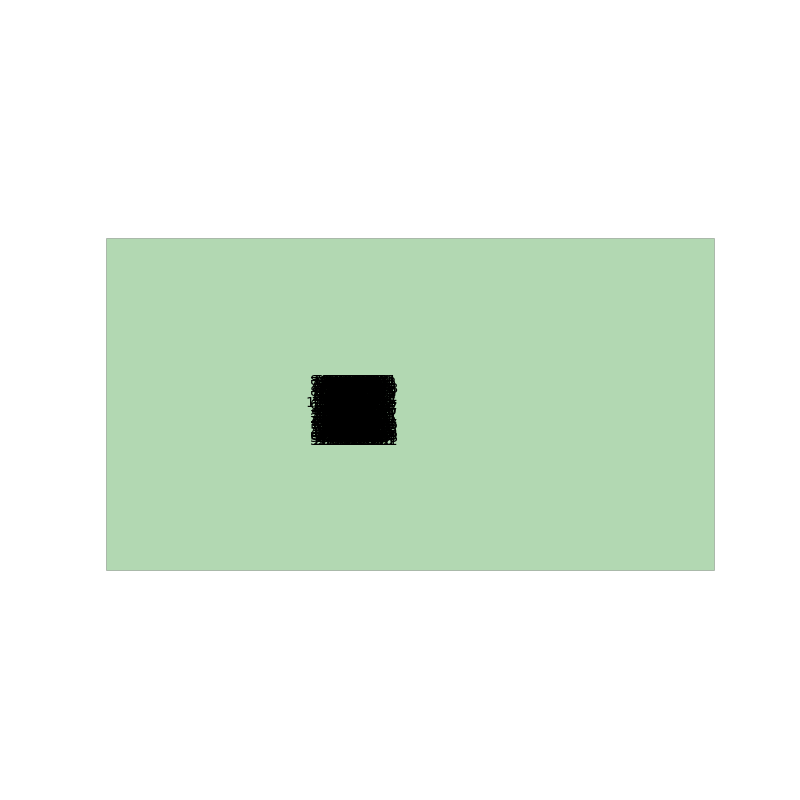

In [151]:
importlib.reload(plt)
%matplotlib widget
plt.close('all')
fig, ax = plt.subplots(figsize=(8, 8))
si.plot_probe_map(recording_chunk,ax=ax,with_channel_ids=True)
ax.invert_yaxis()
#ax.set_facecolor('white')  # Set the background color to white
ax.axis('off')  # Turn off the axes
fig.show()

In [79]:
fs = recording_mmap.get_sampling_frequency()
start_frame = int(0 * fs)
end_frame = int(300 * fs)

recording_slice = recording_mmap.frame_slice(start_frame, end_frame)
num_channels = recording_chunk.get_num_channels()
manual_abs_thresholds = np.full(num_channels, 1)  # µV

# Now run detect_peaks with custom noise levels
peaks = detect_peaks(
    recording=recording_slice,
    method='by_channel',
    peak_sign='neg',
    detect_threshold=10,         # k = 1 → just use manual_abs_thresholds
    noise_levels=manual_abs_thresholds,  # These are already in µV     the data is 
    chunk_duration='300s',
    n_jobs=32,
    progress_bar=True
)


In [80]:
fs = recording_mmap.get_sampling_frequency()
start_frame = int(600 * fs)
end_frame = int(900 * fs)

recording_slice = recording_mmap.frame_slice(start_frame, end_frame)
num_channels = recording_chunk.get_num_channels()
manual_abs_thresholds = np.full(num_channels, 1)  # µV

# Now run detect_peaks with custom noise levels
peaks3 = detect_peaks(
    recording=recording_slice,
    method='by_channel',
    peak_sign='neg',
    detect_threshold=10,         # k = 1 → just use manual_abs_thresholds
    noise_levels=manual_abs_thresholds,  # These are already in µV     the data is 
    chunk_duration='300s',
    n_jobs=32,
    progress_bar=True
)


In [90]:
import numpy as np

channels, counts = np.unique(peaks2['channel_index'], return_counts=True)
for ch, count in zip(channels, counts):
    print(ch, count)
    print(f"Channel {recording_mmap.get_channel_ids()[ch]} → {count} spikes")

1 20
Channel 2 → 20 spikes
2 1029
Channel 4 → 1029 spikes
4 49
Channel 8 → 49 spikes
6 7
Channel 12 → 7 spikes
7 11
Channel 14 → 11 spikes
8 7
Channel 16 → 7 spikes
10 2
Channel 20 → 2 spikes
13 532
Channel 26 → 532 spikes
14 130
Channel 28 → 130 spikes
15 158
Channel 30 → 158 spikes
16 4
Channel 32 → 4 spikes
17 303
Channel 34 → 303 spikes
19 9890
Channel 38 → 9890 spikes
20 118
Channel 40 → 118 spikes
21 347
Channel 42 → 347 spikes
24 379
Channel 48 → 379 spikes
25 35
Channel 50 → 35 spikes
27 92
Channel 54 → 92 spikes
29 197
Channel 58 → 197 spikes
30 1
Channel 60 → 1 spikes
31 56
Channel 62 → 56 spikes
32 120
Channel 64 → 120 spikes
33 692
Channel 66 → 692 spikes
35 120
Channel 70 → 120 spikes
37 548
Channel 74 → 548 spikes
40 14
Channel 80 → 14 spikes
42 85
Channel 84 → 85 spikes
44 187
Channel 88 → 187 spikes
45 435
Channel 90 → 435 spikes
47 496
Channel 94 → 496 spikes
48 825
Channel 98 → 825 spikes
50 413
Channel 102 → 413 spikes
51 214
Channel 104 → 214 spikes
54 183
Channel 1

In [91]:
import numpy as np

channels, counts = np.unique(peaks3['channel_index'], return_counts=True)
for ch, count in zip(channels, counts):
    print(f"Channel {recording_mmap.get_channel_ids()[ch]} → {count} spikes")

Channel 2 → 23 spikes
Channel 4 → 924 spikes
Channel 8 → 49 spikes
Channel 12 → 13 spikes
Channel 14 → 12 spikes
Channel 16 → 11 spikes
Channel 20 → 1 spikes
Channel 26 → 514 spikes
Channel 28 → 131 spikes
Channel 30 → 141 spikes
Channel 32 → 8 spikes
Channel 38 → 11086 spikes
Channel 40 → 108 spikes
Channel 42 → 2 spikes
Channel 48 → 377 spikes
Channel 50 → 29 spikes
Channel 54 → 84 spikes
Channel 58 → 172 spikes
Channel 62 → 65 spikes
Channel 64 → 107 spikes
Channel 66 → 454 spikes
Channel 70 → 122 spikes
Channel 74 → 531 spikes
Channel 80 → 16 spikes
Channel 84 → 83 spikes
Channel 88 → 169 spikes
Channel 90 → 351 spikes
Channel 94 → 514 spikes
Channel 98 → 768 spikes
Channel 102 → 386 spikes
Channel 104 → 172 spikes
Channel 110 → 139 spikes
Channel 112 → 35 spikes
Channel 114 → 549 spikes
Channel 116 → 214 spikes
Channel 118 → 130 spikes
Channel 126 → 484 spikes
Channel 130 → 196 spikes
Channel 138 → 205 spikes
Channel 148 → 18 spikes
Channel 158 → 20 spikes
Channel 170 → 35 spikes


In [119]:
peaks2['sample_index'][peaks2['channel_index']==100]

array([    250,     256,     666, ..., 5999389, 5999428, 5999986])

In [57]:
import numpy as np

channels, counts = np.unique(peaks3['channel_index'], return_counts=True)
for ch, count in zip(channels, counts):
    print(f"Channel {ch} → {count} spikes")

#statistics of counts

# Basic statistics
print(f"Total active channels: {len(channels)}")
print(f"Total spikes detected: {np.sum(counts)}")
print(f"Mean spike count: {np.mean(counts):.2f}")
print(f"Median spike count: {np.median(counts):.2f}")
print(f"Standard deviation: {np.std(counts):.2f}")
print(f"Min spike count: {np.min(counts)}")
print(f"Max spike count: {np.max(counts)}")

# Optional: percentiles
print(f"25th percentile: {np.percentile(counts, 25):.2f}")
print(f"75th percentile: {np.percentile(counts, 75):.2f}")


Channel 1 → 79 spikes
Channel 2 → 1413 spikes
Channel 3 → 35859 spikes
Channel 4 → 79 spikes
Channel 6 → 18 spikes
Channel 7 → 59 spikes
Channel 8 → 453 spikes
Channel 9 → 37530 spikes
Channel 10 → 19 spikes
Channel 12 → 35859 spikes
Channel 13 → 526 spikes
Channel 14 → 178 spikes
Channel 15 → 250 spikes
Channel 16 → 55 spikes
Channel 18 → 1 spikes
Channel 20 → 224 spikes
Channel 21 → 48 spikes
Channel 23 → 35859 spikes
Channel 24 → 464 spikes
Channel 25 → 195 spikes
Channel 27 → 408 spikes
Channel 28 → 3 spikes
Channel 29 → 221 spikes
Channel 30 → 20 spikes
Channel 31 → 251 spikes
Channel 32 → 131 spikes
Channel 33 → 517 spikes
Channel 34 → 2 spikes
Channel 35 → 217 spikes
Channel 36 → 1 spikes
Channel 37 → 559 spikes
Channel 38 → 3 spikes
Channel 39 → 35859 spikes
Channel 40 → 26 spikes
Channel 41 → 35859 spikes
Channel 42 → 120 spikes
Channel 44 → 381440 spikes
Channel 45 → 411 spikes
Channel 47 → 541 spikes
Channel 48 → 796 spikes
Channel 50 → 627 spikes
Channel 51 → 470 spikes
Cha

In [117]:
target_channel = "100"
print(recording_mmap.get_channel_ids())
target_channel_idx = np.where(recording_mmap.get_channel_ids()==target_channel)[0][0]
sample_indices = peaks2['sample_index'][peaks2['channel_index'] == target_channel_idx]
sample_indices

['0' '2' '4' '6' '8' '10' '12' '14' '16' '18' '20' '22' '24' '26' '28'
 '30' '32' '34' '36' '38' '40' '42' '44' '46' '48' '50' '52' '54' '56'
 '58' '60' '62' '64' '66' '68' '70' '72' '74' '76' '78' '80' '82' '84'
 '86' '88' '90' '92' '94' '98' '100' '102' '104' '106' '108' '110' '112'
 '114' '116' '118' '122' '126' '130' '134' '136' '138' '142' '146' '148'
 '152' '154' '158' '162' '164' '166' '168' '170' '174' '178' '180' '182'
 '186' '190' '194' '198' '202' '206' '210' '214' '218' '220' '222' '226'
 '230' '234' '236' '238' '240' '242' '244' '246' '248' '250' '252' '254'
 '258' '384' '386' '388' '392' '396' '398' '404' '416' '420' '424' '512'
 '516' '522' '524' '526' '528' '532' '538' '540' '544' '546' '548' '550'
 '552' '554' '556' '558' '560' '562' '564' '566' '568' '570' '572' '574'
 '576' '578' '580' '582' '584' '586' '588' '590' '592' '594' '596' '598'
 '600' '602' '604' '606' '608' '610' '612' '614' '616' '618' '620' '622'
 '624' '626' '628' '630' '632' '634' '636' '638' '640' '6

array([], dtype=int64)

(20000, 529)
[0. 0. 0. ... 0. 0. 0.]
49
[    250     256     666 ... 5999389 5999428 5999986]
[   96   302   477   579   769   858  1018  1457  1485  1856  2322  2436
  2880  3391  3460  3582  3663  4124  4187  4191  4397  4536  4583  4926
  5119  5126  5163  5175  5222  5230  5261  5265  5324  5583  5838  5843
  5903  5954  6184  6302  6682  6758  6817  7401  7566  7608  7865  8265
  8439  8478  8577  8813  8910  8951  9042  9393  9549  9584  9679  9760
  9944 10072 10495 10679 11038 11122 11209 11312 11448 11684 11701 11860
 11962 11967 11993 12105 12159 12228 12270 12489 12909 13072 13124 13181
 13206 13262 13392 13631 13651 14694 14703 14736 14822 15065 15097 15126
 15500 15620 15817 15952 16023 16160 16305 16315 16402 16601 16918 17057
 17117 17409 17412 17439 17578 17911 18294 18360 18703 18983 19139 19233
 19711]


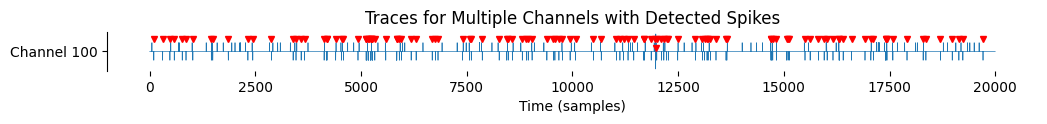

In [133]:
import os

import numpy as np
import matplotlib.pyplot as plt
# Import the detect_peaks function
%matplotlib inline
channels_to_plot = [100] 
fs = recording_chunk.get_sampling_frequency()
start_time = 42.75 # Start time in seconds
end_time = 43.75 # End time in seconds
# Get traces for the specified range
start_frame = int(300*fs)
end_frame =int(600*fs)

recording_slice = recording_chunk.frame_slice(start_frame, end_frame)
traces = recording_slice.get_traces(start_frame=int(start_time*fs), end_frame=int(end_time*fs), segment_index=0,return_scaled=True)
print(traces.shape)
stim_channel ="38"

plt.close('all')
# Adjust figure height dynamically based on the number of channels
plt.figure(figsize=(12, len(channels_to_plot) * 0.5))  # Increase height for better spacing

# Loop through the channels and plot each
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store channel names for labeling
offset = 10
for i, channel in enumerate(channels_to_plot):
    # Get the trace for the current channel
    trace = traces[:, channel]
    print(trace)
    # Detect peaks using the detect_peaks function
    #peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)
    
    # Convert peaks_sample_inds to integers
    stim_channel_idx = np.where(recording_mmap.get_channel_ids() == stim_channel)[0][0]
    target_channel_idx = np.where(recording_mmap.get_channel_ids() == str(channel))[0][0]
    print(target_channel_idx)
    peaks_sample_inds =peaks2['sample_index'][peaks2['channel_index'] == channel]
    print(peaks_sample_inds)
    stim_sample_inds = peaks2['sample_index'][peaks2['channel_index'] == 38]
    spike_marker_offset = 15
    
    # Plot the trace with increased spacing
    plt.plot(
        trace + i * offset,  # Increase the offset to 200 for better spacing
        label=f'Channel {channel}', 
        rasterized=True,  # Rasterize the line plots for faster rendering
        linewidth=0.5  # Use thinner lines for better performance
    )
    peaks_sample_inds = (peaks_sample_inds[(peaks_sample_inds > int(start_time * fs)) & (peaks_sample_inds < int(end_time * fs))]-int(start_time * fs))
    print(peaks_sample_inds)
    # Mark the detected spikes with red triangles
    plt.plot(
        peaks_sample_inds, 
        trace[peaks_sample_inds] + i * offset + spike_marker_offset,  # Match the increased offset
        'rv',  # Red triangles
        markersize=4, 
        label=f'Spikes Channel {channel}'
    )
    
    # Add y-axis tick position and label
    yticks_positions.append(i * offset)
    yticks_labels.append(f'Channel {channel}')

# Customize the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Multiple Channels with Detected Spikes')

# Add y-axis ticks with channel names
plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
output_path = './savetraces_multiple_channels_with_spikes.pdf'  # Replace with your desired path
plt.show() 
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)  # Save with high resolution
 # Show the plot
# Close the plot to free memory
plt.close()

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
from helper_functions import detect_peaks_stddev  # Import the detect_peaks function
%matplotlib inline
channels_to_plot = [38,100] 
fs = recording_mmap.get_sampling_frequency()
start_time =300 # Start time in seconds
end_time = 305# End time in seconds
# Get traces for the specified range
traces = recording_mmap.get_traces(start_frame=int(start_time*fs), end_frame=int(end_time*fs), segment_index=0, return_scaled=True)



# Adjust figure height dynamically based on the number of channels
plt.figure(figsize=(12, len(channels_to_plot) * 0.5))  # Increase height for better spacing

# Loop through the channels and plot each
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store channel names for labeling

for i, channel in enumerate(channels_to_plot):
    # Get the trace for the current channel
    trace = traces[:, channel]
    

    
    # Convert peaks_sample_inds to integers
    peaks_sample_inds = peaks['sample_index']
    spike_marker_offset = 100
    
    # Plot the trace with increased spacing
    plt.plot(
        trace + i * 200,  # Increase the offset to 200 for better spacing
        label=f'Channel {channel}', 
        rasterized=True,  # Rasterize the line plots for faster rendering
        linewidth=0.5  # Use thinner lines for better performance
    )
    
    # Mark the detected spikes with red triangles
    plt.plot(
        peaks_sample_inds, 
        trace[peaks_sample_inds] + i * 200 + spike_marker_offset,  # Match the increased offset
        'rv',  # Red triangles
        markersize=4, 
        label=f'Spikes Channel {channel}'
    )
    
    # Add y-axis tick position and label
    yticks_positions.append(i * 200)
    yticks_labels.append(f'Channel {channel}')

# Customize the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Multiple Channels with Detected Spikes')

# Add y-axis ticks with channel names
plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
output_path = './savetraces_multiple_channels_with_spikes.pdf'  # Replace with your desired path
plt.show() 
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)  # Save with high resolution
 # Show the plot
# Close the plot to free memory
plt.close()


ValueError: 38 is not in list

In [27]:
print(peaks.dtype)

[('sample_index', '<i8'), ('channel_index', '<i8'), ('amplitude', '<f8'), ('segment_index', '<i8')]


In [50]:
len(recording_chunk.get_channel_ids())

529

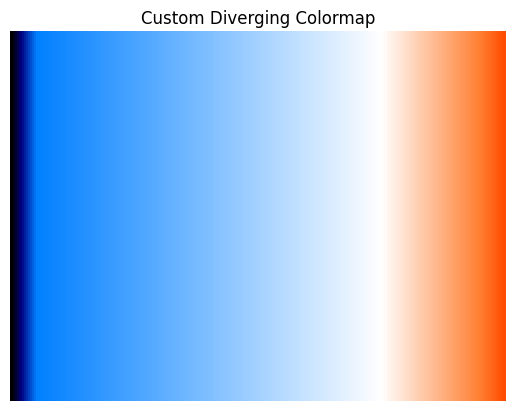

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def custom_diverging_colormap(n_colors=256):
    # [position, R, G, B]
    control_points = np.array([
        [0.00, 0.0, 0.0, 0.0],    # Black
        [0.02, 0.0, 0.0, 0.5],    # Dark Blue
        [0.05, 0.0, 0.5, 1.0],    # Light Blue
        [0.75, 1.0, 1.0, 1.0],    # White
        [0.95, 1.0, 0.5, 0.2],    # Light Orange
        [1.00, 1.0, 0.3, 0.0],    # Red
    ])
    
    x = control_points[:, 0]
    r = control_points[:, 1]
    g = control_points[:, 2]
    b = control_points[:, 3]

    xq = np.linspace(0, 1, n_colors)
    rq = np.interp(xq, x, r)
    gq = np.interp(xq, x, g)
    bq = np.interp(xq, x, b)

    colors = np.vstack([rq, gq, bq]).T
    return LinearSegmentedColormap.from_list("custom_diverging", colors)

# Example usage:
cmap = custom_diverging_colormap()
plt.imshow(np.linspace(0, 1, 256)[None, :], aspect='auto', cmap=cmap)
plt.title("Custom Diverging Colormap")
plt.axis('off')
plt.show()

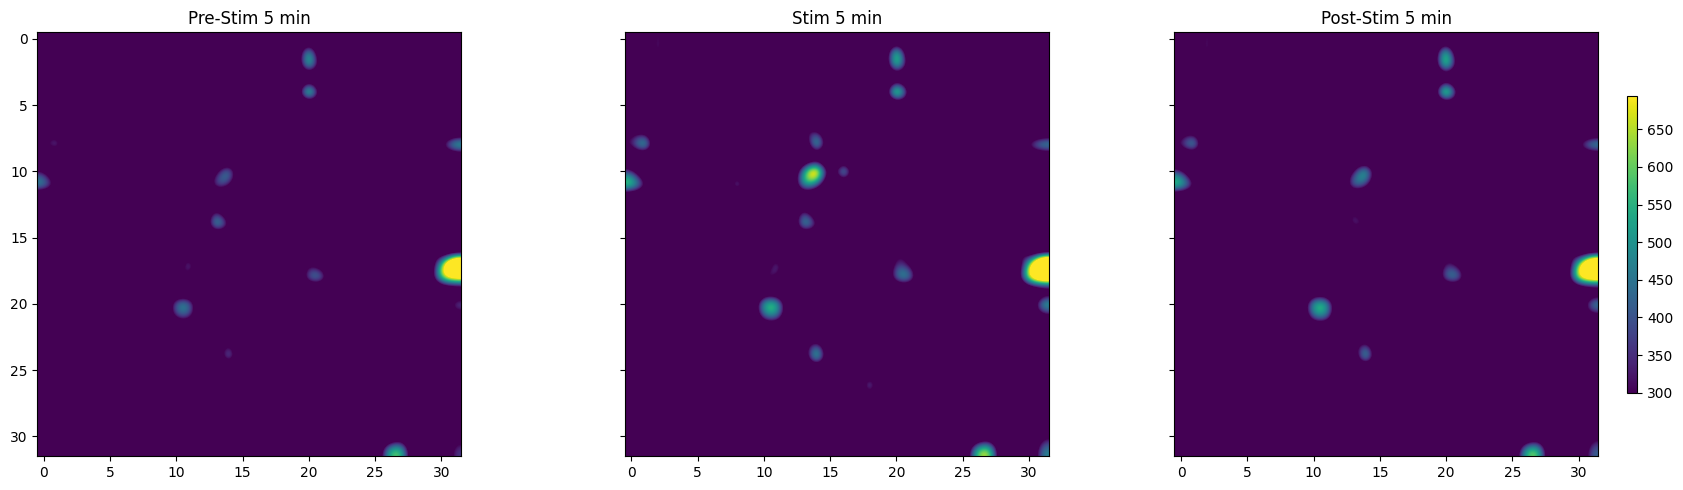

In [106]:
from scipy.stats import binned_statistic_2d
import numpy as np
import matplotlib.pyplot as plt

def compute_stat(peaks_tmp, locs, bins=32):
    chan_ids, counts = np.unique(peaks_tmp['channel_index'], return_counts=True)
    locs_dict = dict(zip(range(len(locs)), locs))
    xy = np.array([locs_dict[ch] for ch in chan_ids])
    stat, xedges, yedges, _ = binned_statistic_2d(
        xy[:, 0], xy[:, 1], values=counts + 1, statistic='sum', bins=bins
    )
    return stat, xedges, yedges

#remove channel 38 from peak
channel_idx = np.where(recording_chunk.get_channel_ids() == "38")[0][0]
peaks = peaks[peaks['channel_index'] != channel_idx]
peaks2 = peaks2[peaks2['channel_index'] != channel_idx]
peaks3 = peaks3[peaks3['channel_index'] != channel_idx]
# Step 1: Compute stats
stat1, xedges, yedges = compute_stat(peaks, locs)
stat2, _, _ = compute_stat(peaks2, locs)
stat3, _, _ = compute_stat(peaks3, locs)

# Step 2: Global vmax
vmax_global = np.percentile(np.concatenate([stat1.ravel(), stat2.ravel(), stat3.ravel()]), 99)

# Step 3: Plot with same vmax
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
for ax, stat, title in zip(axs, [stat1, stat2, stat3], 
                           ["Pre-Stim 5 min", "Stim 5 min", "Post-Stim 5 min"]):
    im = ax.imshow(stat.T, origin='lower', cmap='viridis', 
                   interpolation='bicubic', vmin= 300,vmax=vmax_global)
    ax.set_title(title)
    ax.invert_yaxis()

# Shared colorbar
cbar = fig.colorbar(im, ax=axs[2], location='right', shrink=0.7, aspect=30)
#cbar.set_label("Spike Count (+1, binned)")

# Add a legend to the right side after fig3
handles, labels = axs[2].get_legend_handles_labels()
#fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.75, 0.5))
#cbar.set_label("Spike Count (+1, binned)")
plt.tight_layout()
#plt.show()
plt.savefig('./stims.png', dpi=300)



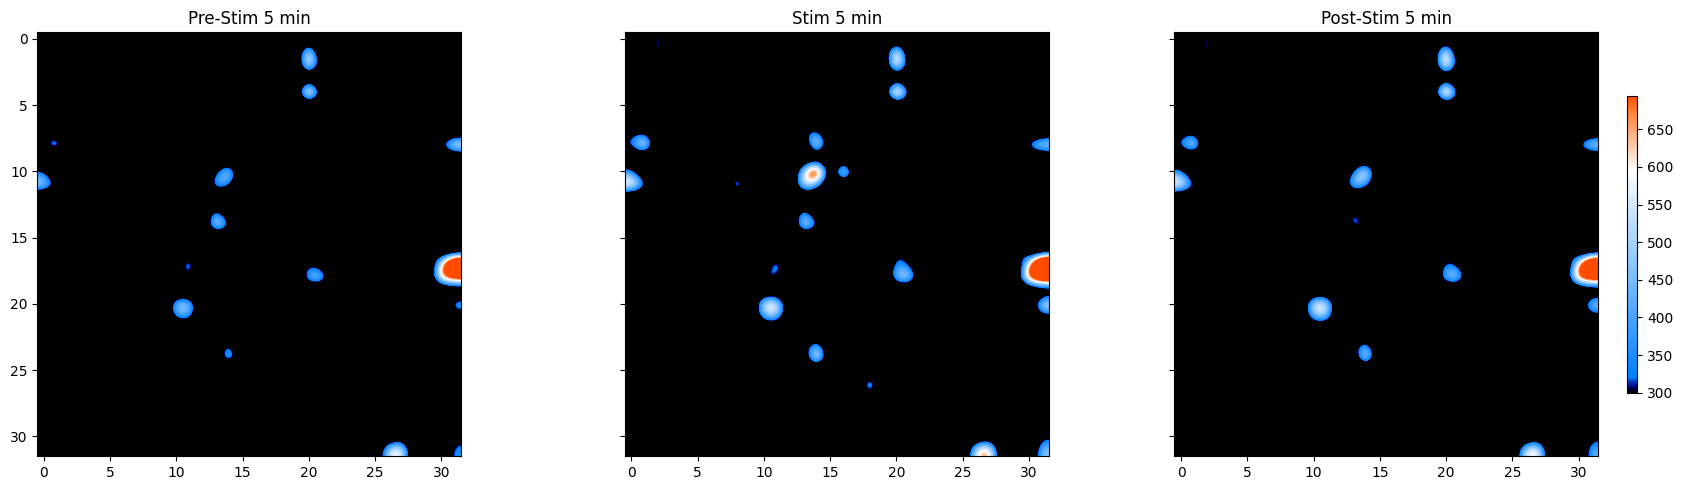

In [109]:
# Import your custom colormap function first
def custom_diverging_colormap(n_colors=256):
    import numpy as np
    from matplotlib.colors import LinearSegmentedColormap

    control_points = np.array([
        [0.00, 0.0, 0.0, 0.0],
        [0.02, 0.0, 0.0, 0.5],
        [0.05, 0.0, 0.5, 1.0],
        [0.75, 1.0, 1.0, 1.0],
        [0.95, 1.0, 0.5, 0.2],
        [1.00, 1.0, 0.3, 0.0],
    ])
    x = control_points[:, 0]
    r = control_points[:, 1]
    g = control_points[:, 2]
    b = control_points[:, 3]
    xq = np.linspace(0, 1, n_colors)
    rq = np.interp(xq, x, r)
    gq = np.interp(xq, x, g)
    bq = np.interp(xq, x, b)
    colors = np.vstack([rq, gq, bq]).T
    return LinearSegmentedColormap.from_list("custom_diverging", colors)

# Then, plug it into your plotting code
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
for ax, stat, title in zip(axs, [stat1, stat2, stat3], 
                           ["Pre-Stim 5 min", "Stim 5 min", "Post-Stim 5 min"]):
    im = ax.imshow(stat.T, origin='lower',
                   cmap=custom_diverging_colormap(),
                   interpolation='bicubic',
                   vmin=300, vmax=vmax_global)
    ax.set_title(title)
    ax.invert_yaxis()

# Shared colorbar
cbar = fig.colorbar(im, ax=axs[2], location='right', shrink=0.7, aspect=30)

plt.tight_layout()
plt.savefig('./stims_custom_cmap.png', dpi=300)

In [48]:
locs_dict.keys()

dict_keys(['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32', '34', '36', '38', '40', '42', '44', '46', '48', '50', '52', '54', '56', '58', '60', '62', '64', '66', '68', '70', '72', '74', '76', '78', '80', '82', '84', '86', '88', '90', '92', '94', '98', '100', '102', '104', '106', '108', '110', '112', '114', '116', '118', '122', '126', '130', '134', '136', '138', '142', '146', '148', '152', '154', '158', '162', '164', '166', '168', '170', '174', '178', '180', '182', '186', '190', '194', '198', '202', '206', '210', '214', '218', '220', '222', '226', '230', '234', '236', '238', '240', '242', '244', '246', '248', '250', '252', '254', '258', '384', '386', '388', '392', '396', '398', '404', '416', '420', '424', '512', '516', '522', '524', '526', '528', '532', '538', '540', '544', '546', '548', '550', '552', '554', '556', '558', '560', '562', '564', '566', '568', '570', '572', '574', '576', '578', '580', '582', '584', '586', '588', '590', '592', 

In [24]:
import mea_analysis_pipeline as msp
import helper_functions as helper

Sampling frequency: 20000.0
Number of channels: 529
Number of segments: 1
total_recording: 906.06 s
The directory '/mmpatil/MEA_Analysis_FEB25/IPNAnalysis/Sorting_Intermediate_files' has been emptied.


('The sorting failed.', 'The sorting failed.')

In [ ]:
#get electrode numbers
channel_ids = recording_chunk.get_channel_ids()
elec



# SpikeInterface H5 Data Extraction

In [10]:
def full_analysis(file_path, stim_freq, trial_no, recording_electrode, stim_electrode, artifact_electrode=None):
    trial_data = StimulationAnalysis(file_path, stim_freq, recording_electrode=recording_electrode, stim_electrode=stim_electrode, artifact_electrode=artifact_electrode)

    #trial_data.plot_neuron_print()

    #trial_data.plot_individual_traces('recording', trial_no, bp_filter=True)
    #trial_data.plot_individual_traces('stim', trial_no, bp_filter=True)
    # if artifact_electrode is not None:
    #     trial_data.plot_individual_traces('artifact', trial_no, bp_filter=True, time_range=0.5)

    trial_data.get_spike_counts()
    trial_data.plot_spike_counts('recording', trial_no)
    trial_data.plot_spike_counts('stim', trial_no)
    if artifact_electrode is not None:
        trial_data.plot_spike_counts('artifact', trial_no)

    trial_data.plot_stim_traces(trial_no)

    return trial_data

# 10/23 Experiments

In [ ]:
import h5py

with h5py.File(local_path, 'r') as h5file:
    mapping = h5file['data_store/data0000/settings/mapping']
    channel_ids = [38, 820, 100]

    print("Mapping shape:", mapping.shape)
    print("Mapping dtype:", mapping.dtype)
    print("Mapping data:", mapping[:])
    # Extract the mapping data for the specified channels
    for channel_id in channel_ids:
        if channel_id < mapping.shape[0]:
            print(f"Mapping for channel {channel_id}:", mapping[channel_id])
        else:
            print(f"Channel {channel_id} not found in mapping data.")


Mapping shape: (529,)
Mapping dtype: [('channel', '<i4'), ('electrode', '<i4'), ('x', '<f8'), ('y', '<f8')]
Mapping data: [(   0, 14602, 1435. , 1155. ) (   2, 13300, 1750. , 1050. )
 (   4, 14180, 1750. , 1120. ) (   6, 11305, 1487.5,  892.5)
 (   8, 14176, 1680. , 1120. ) (  10, 11309, 1557.5,  892.5)
 (  12, 14383, 1452.5, 1137.5) (  14, 11751, 1592.5,  927.5)
 (  16, 14160, 1400. , 1120. ) (  18, 11962, 1435. ,  945. )
 (  20, 13519, 1732.5, 1067.5) (  22, 11747, 1522.5,  927.5)
 (  24, 13296, 1680. , 1050. ) (  26, 12189, 1557.5,  962.5)
 (  28, 13941, 1417.5, 1102.5) (  30, 12412, 1610. ,  980. )
 (  32, 13718, 1365. , 1085. ) (  34, 12185, 1487.5,  962.5)
 (  36, 12858, 1715. , 1015. ) (  38, 12627, 1522.5,  997.5)
 (  40, 13503, 1452.5, 1067.5) (  42, 12631, 1592.5,  997.5)
 (  44, 13280, 1400. , 1050. ) (  46, 12842, 1435. , 1015. )
 (  48, 12838, 1365. , 1015. ) (  50, 13284, 1470. , 1050. )
 (  52, 12197, 1697.5,  962.5) (  54, 13069, 1557.5, 1032.5)
 (  56, 13061, 1417.5, 1

# Trial 4 

In [ ]:
fp = '/mnt/disk20tb/PrimaryNeuronData/Maxtwo/Stimulation_MaxOnePlus_MP/250423/P002820/Trace_20250423_16_49_17.raw.h5'

trial4_data = StimulationAnalysis(fp, stim_frequency=1.0, recording_electrode=14395, stim_electrode=12627, artifact_electrode=12848)
sc = trial4_data.get_spike_counts()
trial4_data.pre_stim_length = 300
trial4_data.stim_length = 300
trial4_data.visible_artifact = True

In [7]:
print(trial4_data.channel_dict)
print(sc.tail())

{'Stim Channel': 38, 'Recording Channel': 100, 'Artifact Channel': 820}
              Time Range Channel 38 Channel 100 Channel 820
85  17000000 to 17200000         []          []          []
86  17200000 to 17400000         []          []          []
87  17400000 to 17600000         []          []          []
88  17600000 to 17800000         []          []          []
89  17800000 to 18000000         []          []          []


0
Pre-stim total spike count: 0
Stim total spike count: 0
Post-stim spike count: 0


TypeError: '>' not supported between instances of 'float' and 'NoneType'

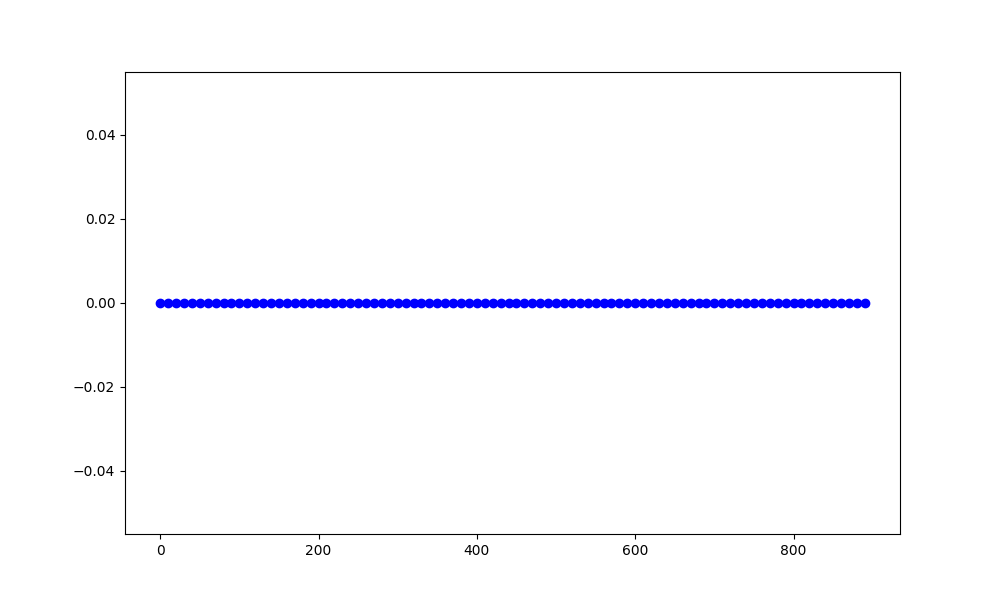

In [8]:
trial4_data.plot_spike_counts('recording', trial_no=4)

{'Stim Channel': 204, 'Recording Channel': 572, 'Artifact Channel': 580}
         Time Range Channel 204             Channel 572 Channel 580
0  814233 to 814533        [40]  [29, 40, 99, 170, 262]        [39]


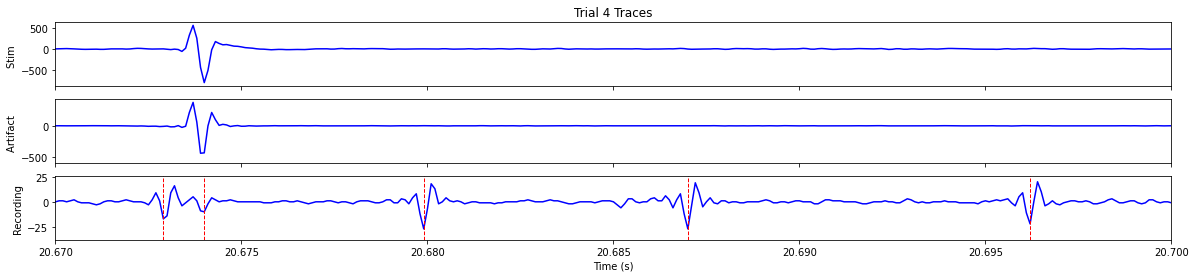

Start time: 81.42330000000001
End Time: 81.45330000000001


In [5]:
print(trial4_data.channel_dict)
start_time, end_time = trial4_data.plot_stim_traces(4, start_at=20.67, time_range=0.03)#, time_range=0.1, start_at=10.9)
peaks = trial4_data.get_spike_counts_in_range(start_time, end_time)

# Trial 3

In [2]:
fp = '/mnt/disk15tb/nathaniel/Clean Stim N1/000185/data.raw.h5'
t3_data = StimulationAnalysis(fp, stim_frequency=0.25, recording_electrode=8165, stim_electrode=9925, artifact_electrode=9924)
t3_data.pre_stim_length = 60
t3_data.stim_length = 60
t3_sc = t3_data.get_spike_counts()


In [20]:
print(t3_sc.tail())

            Time Range Channel 532  \
13  1300000 to 1400000          []   
14  1400000 to 1500000          []   
15  1500000 to 1600000          []   
16  1600000 to 1700000          []   
17  1700000 to 1800000          []   

                                          Channel 536 Channel 632  
13  [3059, 9245, 11243, 16383, 18063, 18761, 19669...          []  
14  [25, 205, 335, 351, 471, 576, 691, 880, 940, 1...          []  
15  [386, 1593, 1630, 1652, 5622, 6163, 7479, 7514...          []  
16  [15250, 17026, 22662, 24280, 27238, 30735, 318...          []  
17  [2532, 9701, 9743, 9879, 9989, 10006, 10056, 1...          []  


<class 'pandas.core.series.Series'>
0    [1483]
Name: Channel 532, dtype: object


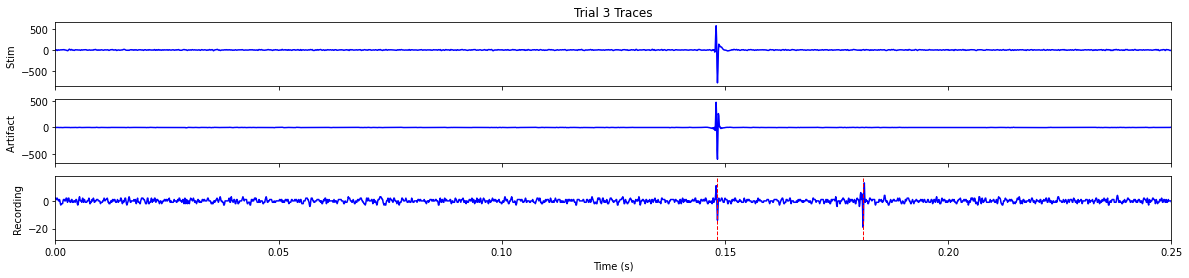

Start time: 60.7533
End Time: 61.0033


(60.7533, 61.0033)

In [3]:
t3_data.plot_stim_traces(3, time_range=0.25)

{'Stim Channel': 532, 'Recording Channel': 536, 'Artifact Channel': 632}
0     [2040, 6639, 10324, 13543, 13589, 22845, 23250...
1     [2514, 5039, 5480, 6455, 6662, 9607, 10905, 11...
2     [215, 4677, 7837, 9205, 9860, 11701, 12734, 14...
3     [816, 3227, 4199, 10543, 10777, 10893, 16144, ...
4     [37, 133, 179, 601, 7881, 11843, 18625, 19035,...
5     [3145, 3190, 3229, 8542, 10975, 12099, 12209, ...
6     [1511, 2574, 3415, 3665, 3731, 3752, 4013, 651...
7     [1571, 3671, 3708, 4073, 6575, 9076, 9088, 107...
8     [44, 1177, 1632, 1642, 1712, 4133, 5764, 6634,...
9     [1427, 1467, 1692, 4193, 4207, 6694, 9196, 113...
10    [1613, 1644, 1751, 1816, 4253, 4611, 6755, 680...
11    [327, 509, 1567, 1812, 3178, 3222, 3451, 4313,...
12    [232, 1183, 13679, 14472, 15235, 16650, 16827,...
13    [3059, 9245, 11243, 16383, 18063, 18761, 19669...
14    [25, 205, 335, 351, 471, 576, 691, 880, 940, 1...
15    [386, 1593, 1630, 1652, 5622, 6163, 7479, 7514...
16    [15250, 17026, 22662, 242

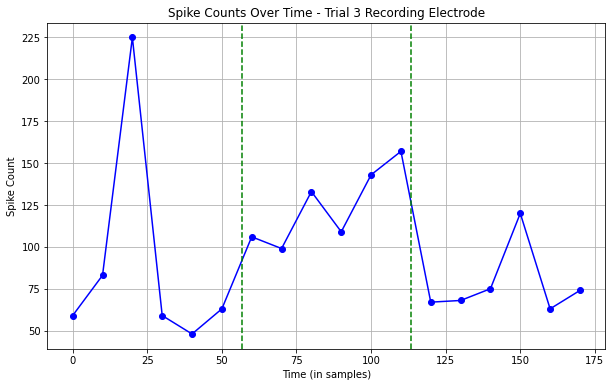

In [4]:
t3_data.visible_artifact=True
print(t3_data.channel_dict)
t3_data.plot_spike_counts('recording', trial_no=3)

In [ ]:
trial3_data = full_analysis(file_path=fp, trial_no=3, recording_electrode=8165, stim_electrode=9925, artifact_electrode=9924)


# Trial 2

In [2]:
fp = '/mnt/disk15tb/nathaniel/Clean Stim N1/000181/data.raw.h5'

t2_data = StimulationAnalysis(fp, stim_frequency=0.25, recording_electrode=8165, stim_electrode=8173)
t2_data.pre_stim_length = 60
t2_data.stim_length = 60
t2_sc = t2_data.get_spike_counts()


In [10]:
print(t2_sc.tail())

            Time Range Channel 580  \
13  1300000 to 1400000          []   
14  1400000 to 1500000          []   
15  1500000 to 1600000          []   
16  1600000 to 1700000          []   
17  1700000 to 1800000          []   

                                          Channel 536  
13  [2102, 3233, 4137, 4712, 5295, 5508, 6490, 755...  
14  [1464, 2848, 14497, 14515, 24314, 27292, 30323...  
15  [2999, 3891, 4268, 8026, 10374, 10459, 10545, ...  
16  [52, 1649, 2243, 3003, 5138, 5988, 6025, 6224,...  
17  [6118, 8208, 8607, 11352, 11392, 14650, 15462,...  


<class 'pandas.core.series.Series'>
0    [1641, 4142, 6644, 9145]
Name: Channel 580, dtype: object


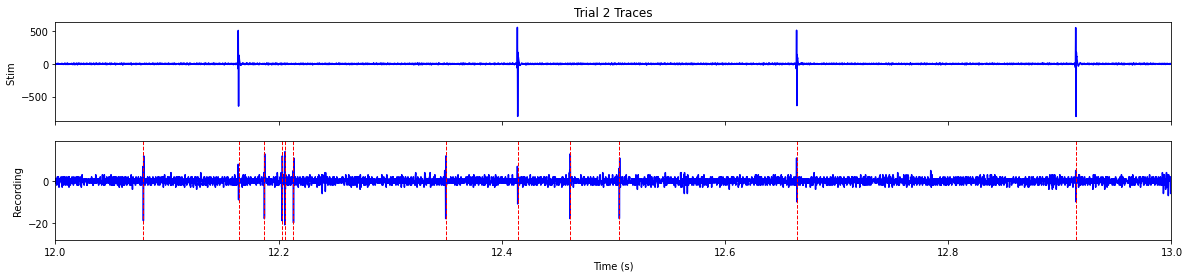

Start time: 72.7666
End Time: 73.7666


(72.7666, 73.7666)

In [4]:
t2_data.plot_stim_traces(2, time_range=1, start_at=12)

            Time Range                                        Channel 580  \
0          0 to 100000                                                 []   
1     100000 to 200000                                                 []   
2     200000 to 300000                                                 []   
3     300000 to 400000                                                 []   
4     400000 to 500000                                                 []   
5     500000 to 600000                                                 []   
6     600000 to 700000  [1730, 4232, 6733, 9235, 11736, 14238, 16739, ...   
7     700000 to 800000  [1790, 4292, 6793, 9295, 11796, 14298, 16799, ...   
8     800000 to 900000  [1850, 4352, 6853, 9355, 11856, 14358, 16859, ...   
9    900000 to 1000000  [1910, 4412, 6913, 9415, 11916, 14418, 16919, ...   
10  1000000 to 1100000  [1970, 4472, 6973, 9475, 11976, 14478, 16979, ...   
11  1100000 to 1200000  [2030, 4532, 7033, 9535, 12036, 14538, 17039, ...   

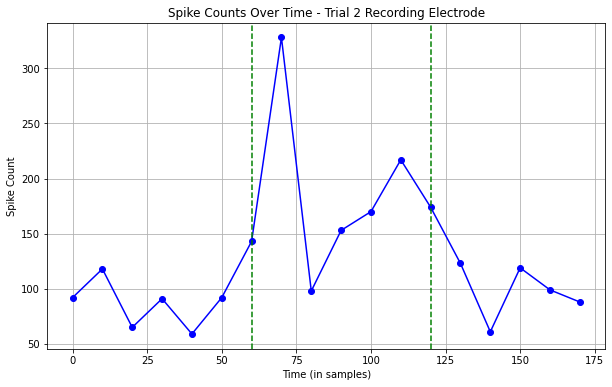

In [5]:
t2_data.visible_artifact = True
t2_data.plot_spike_counts('recording', 2)

# Trial 1

In [3]:
fp = '/mnt/disk15tb/nathaniel/Clean Stim N1/000177/data.raw.h5'

t1_data = StimulationAnalysis(fp, stim_frequency=0.25, recording_electrode=8165, stim_electrode=6405)
t1_data.pre_stim_length = 60
t1_data.stim_length = 60
t1_sc = t1_data.get_spike_counts()


<class 'pandas.core.series.Series'>
0    [615, 3117, 5618, 8120]
Name: Channel 468, dtype: object


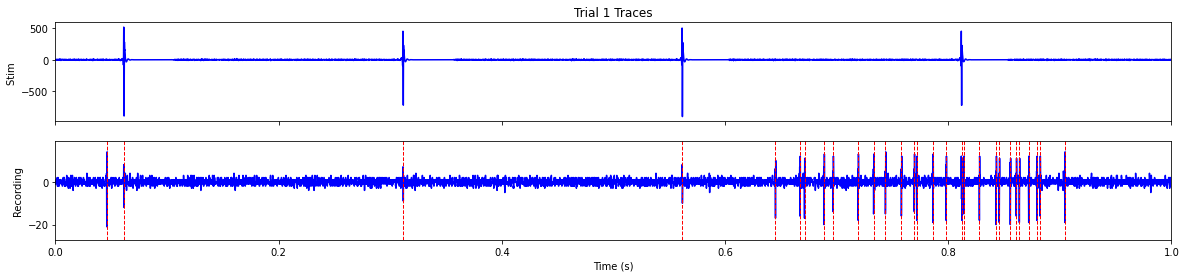

Start time: 60.0933
End Time: 61.0933


(60.0933, 61.0933)

In [4]:
t1_data.plot_stim_traces(1, time_range=1)

            Time Range                                        Channel 468  \
0          0 to 100000                                                 []   
1     100000 to 200000                                                 []   
2     200000 to 300000                                                 []   
3     300000 to 400000                                                 []   
4     400000 to 500000                                                 []   
5     500000 to 600000                                                 []   
6     600000 to 700000  [1548, 4050, 6551, 9053, 11554, 14056, 16557, ...   
7     700000 to 800000  [1608, 4110, 6611, 9113, 11614, 14116, 16617, ...   
8     800000 to 900000  [1668, 4170, 6671, 9173, 11674, 14176, 16677, ...   
9    900000 to 1000000  [1728, 4230, 6731, 9233, 11734, 14236, 16737, ...   
10  1000000 to 1100000  [1788, 4290, 6791, 9293, 11794, 14296, 16797, ...   
11  1100000 to 1200000  [1848, 4350, 6851, 9353, 11854, 14356, 16857, ...   

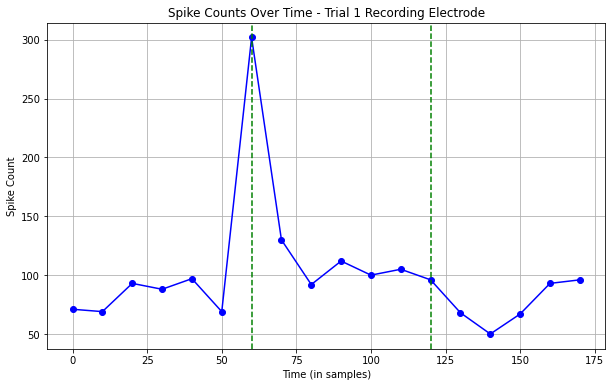

In [5]:
t1_data.visible_artifact = True
t1_data.plot_spike_counts('recording', 1)

In [33]:
fp = '/mnt/disk15tb/nathaniel/000189/data.raw.h5'
recording = se.read_maxwell(fp)

channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()
num_samples = recording.get_num_samples(segment_index=0)
total_recording = recording.get_total_duration()

start_time = 0
end_time = num_samples / fs

print('Sampling frequency:', fs)
print('No. of channels:', num_chan)
print('No. of segments:', num_seg)
print('total_recording:', total_recording)
print('No. of samples:', num_samples)
print(f'Start time: {start_time} seconds')
print(f'End time: {end_time} seconds')

recording_bp = si.bandpass_filter(recording, freq_min=300, freq_max=3000)

# Divide into three chunks: pre-stim, stim, post-stim

chunk_duration = total_recording / 3

samples_per_chunk = int(chunk_duration * fs)

pre_stim_start = 0
pre_stim_end = samples_per_chunk
pre_stim_data = recording_bp.get_traces(channel_ids=['572'], start_frame=pre_stim_start, end_frame=pre_stim_end)
print(recording_bp)
during_stim_start = pre_stim_end 
during_stim_end = pre_stim_end + samples_per_chunk 
during_stim_data = recording_bp.get_traces(channel_ids=['572'], start_frame=during_stim_start, end_frame=during_stim_end) 

post_stim_start = during_stim_end 
post_stim_end = num_samples 
post_stim_data = recording_bp.get_traces(channel_ids=['572'], start_frame=post_stim_start, end_frame=post_stim_end) 




Sampling frequency: 10000.0
No. of channels: 124
No. of segments: 1
total_recording: 182.26
No. of samples: 1822600
Start time: 0 seconds
End time: 182.26 seconds
BandpassFilterRecording: 124 channels - 10000.0Hz - 1 segments - 1,822,600 samples 
                         182.26s (3.04 minutes) - int16 dtype - 431.07 MiB


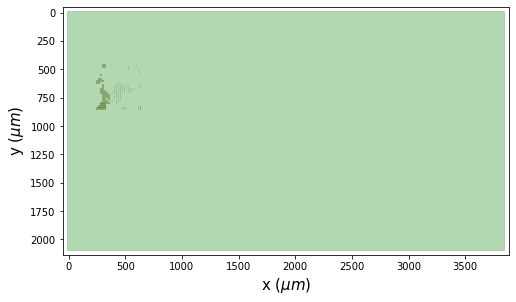

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
si.plot_probe_map(recording_bp, ax=ax, with_channel_ids=False)
ax.invert_yaxis()

# Clean Method N2

## Trial 1

Stim Channel: 950
Recording Channel: 980


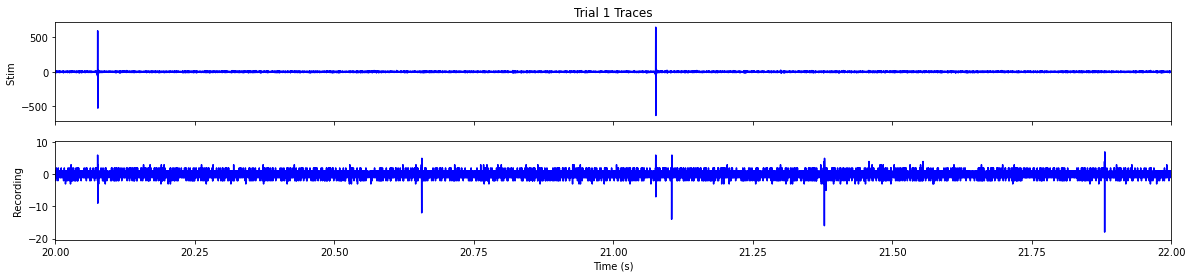

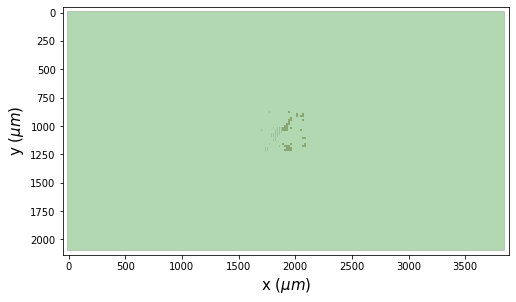

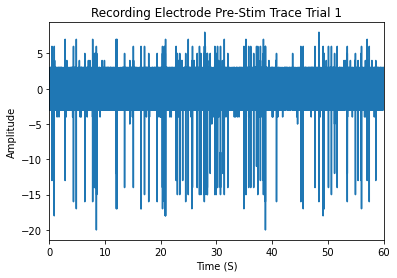

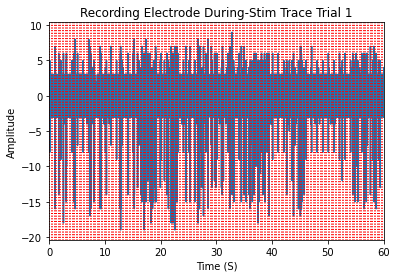

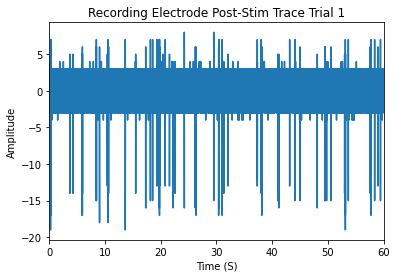

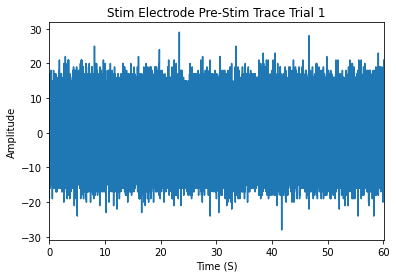

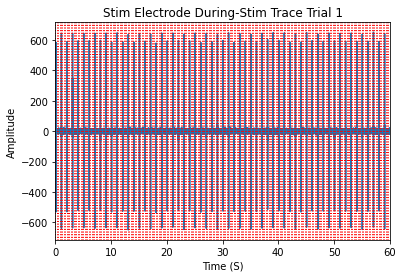

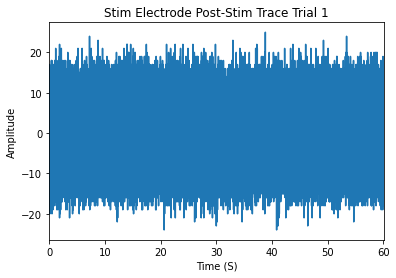

Pre-stim total spike count: 150
Stim total spike count: 198
Post-stim spike count: 141


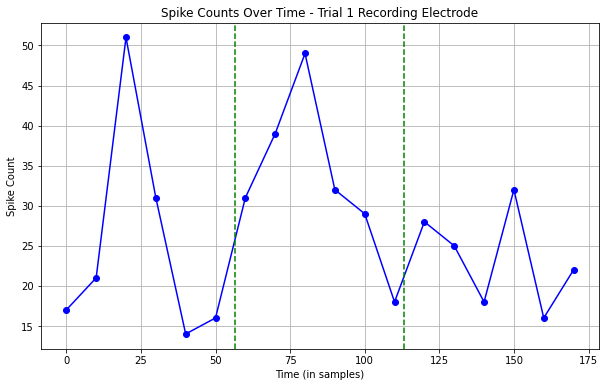

Pre-stim total spike count: 19412
Stim total spike count: 19560
Post-stim spike count: 18992


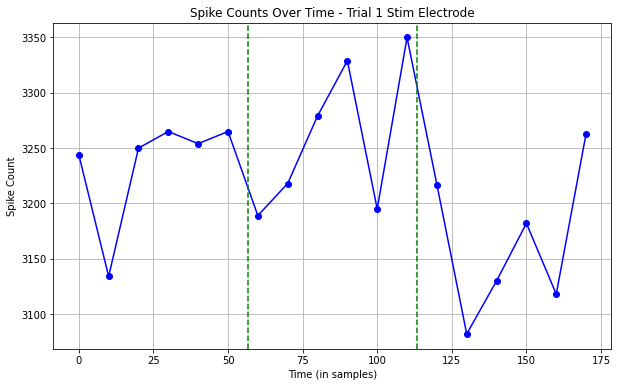

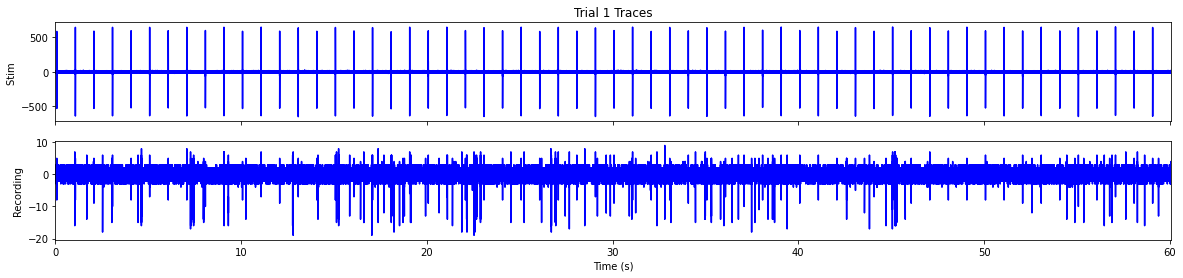

In [27]:
fp = '/mnt/disk15tb/nathaniel/Clean Stim N2/000228/data.raw.h5'
n2_t1_data = StimulationAnalysis(fp, recording_electrode=13306, stim_electrode=14846)
print(f'Stim Channel: {n2_t1_data.stim_channel}')
print(f'Recording Channel: {n2_t1_data.rec_channel}')
#print(n2_t1_data.get_spike_counts())
n2_t1_data.plot_stim_traces(1, bp_filter=True, time_range=2, start_at=20)
full_analysis(fp, 1, recording_electrode=13306, stim_electrode=14846)



## Trial 2

In [2]:
fp = '/mnt/disk15tb/nathaniel/Clean Stim N2/000226/data.raw.h5'
n2_t1_data = StimulationAnalysis(fp, recording_electrode=13306, stim_electrode=13313)
print(f'Stim Channel: {n2_t1_data.stim_channel}')
print(f'Recording Channel: {n2_t1_data.rec_channel}')
#print(n2_t1_data.get_spike_counts())
n2_t1_data.plot_stim_traces(2, bp_filter=True, time_range=3, start_at=1)
full_analysis(fp, 1, recording_electrode=13306, stim_electrode=13313)

TypeError: StimulationAnalysis.__init__() missing 1 required positional argument: 'stim_frequency'

## Trial 3

Stim Channel: 886
Recording Channel: 913


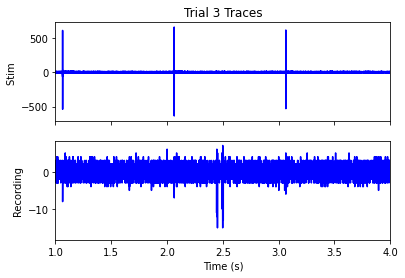

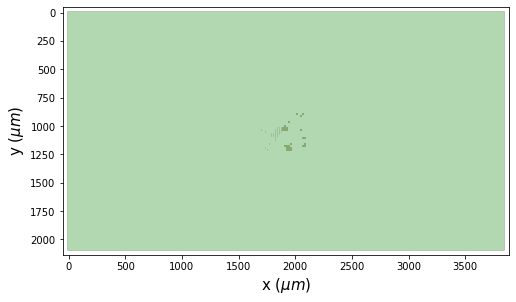

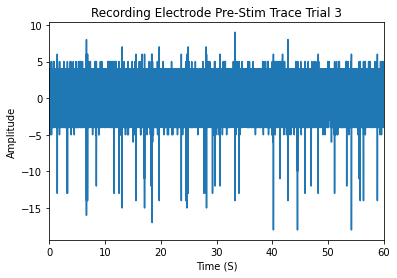

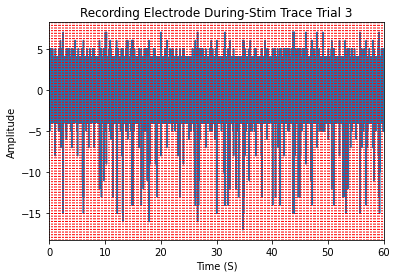

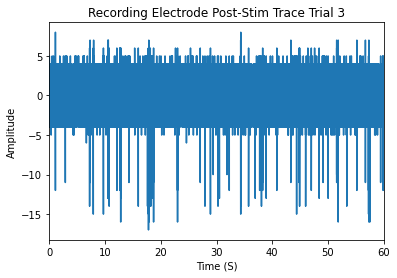

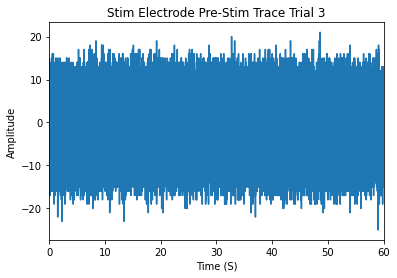

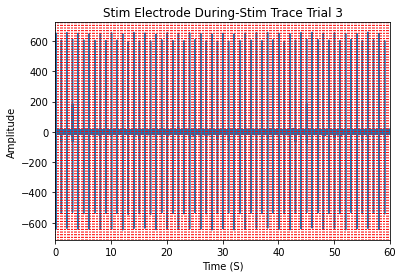

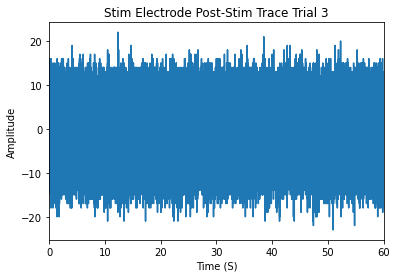

Pre-stim total spike count: 114
Stim total spike count: 151
Post-stim spike count: 179


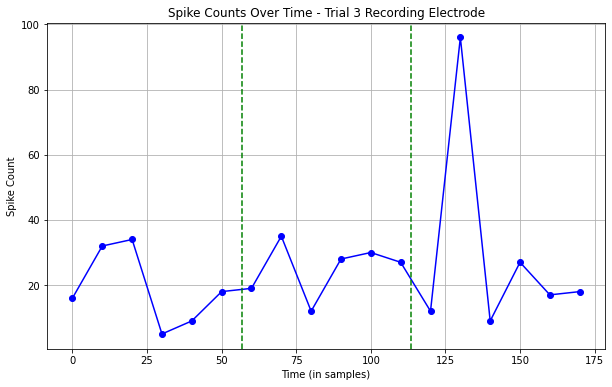

Pre-stim total spike count: 15066
Stim total spike count: 14641
Post-stim spike count: 14272


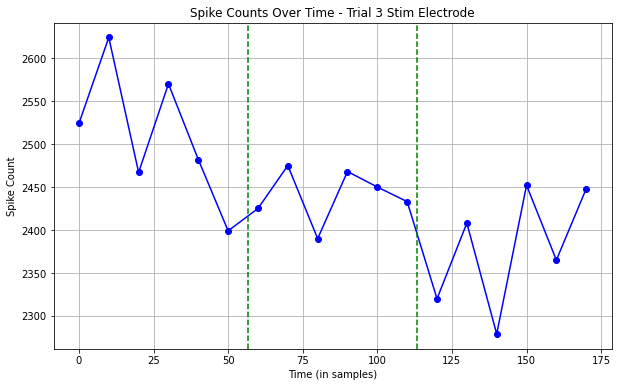

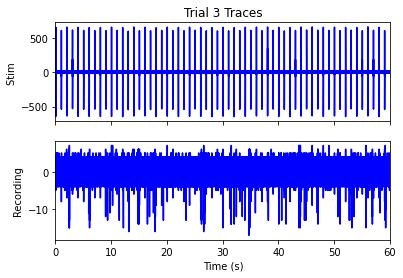

In [5]:
fp = '/mnt/disk15tb/nathaniel/Clean Stim N2/000230/data.raw.h5'
n2_t1_data = StimulationAnalysis(fp, recording_electrode=13306, stim_electrode=13299)
print(f'Stim Channel: {n2_t1_data.stim_channel}')
print(f'Recording Channel: {n2_t1_data.rec_channel}')
#print(n2_t1_data.get_spike_counts())
n2_t1_data.plot_stim_traces(3, bp_filter=True, time_range=3, start_at=1)
full_analysis(fp, 3, recording_electrode=13306, stim_electrode=13299)

## Trial 4

Stim Channel: 950
Recording Channel: 913


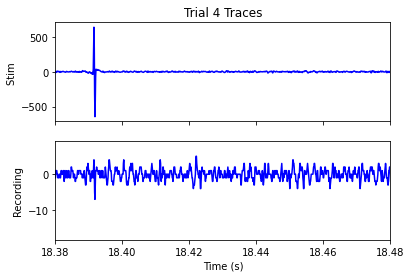

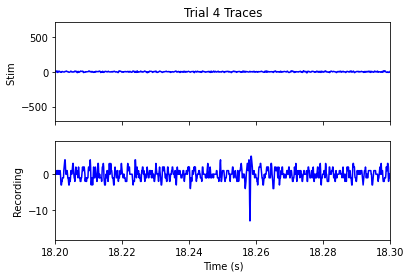

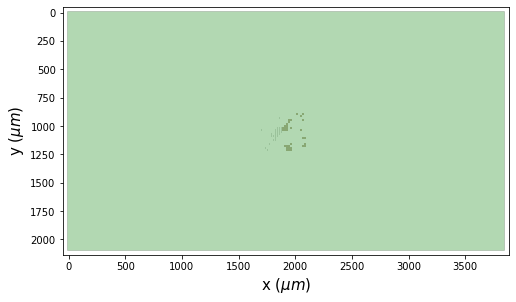

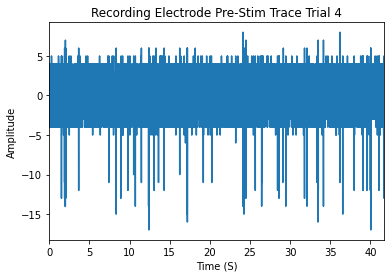

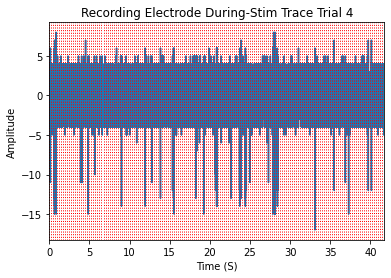

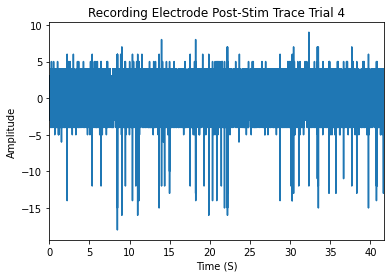

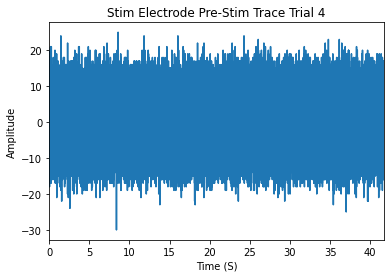

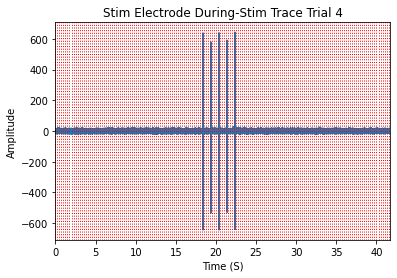

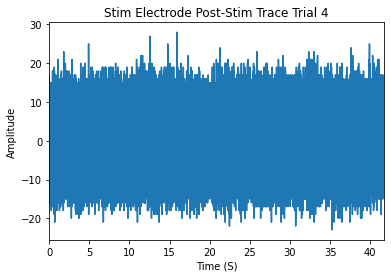

Pre-stim total spike count: 89
Stim total spike count: 135
Post-stim spike count: 82


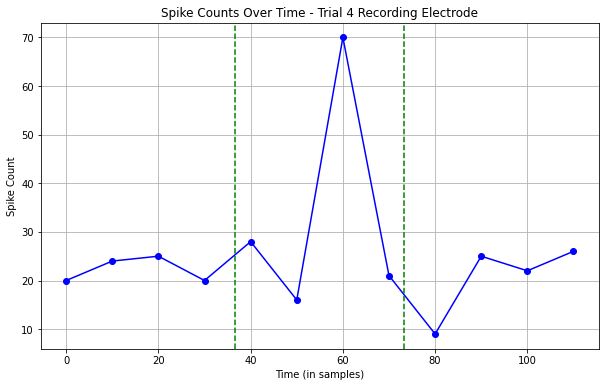

Pre-stim total spike count: 13575
Stim total spike count: 13631
Post-stim spike count: 13376


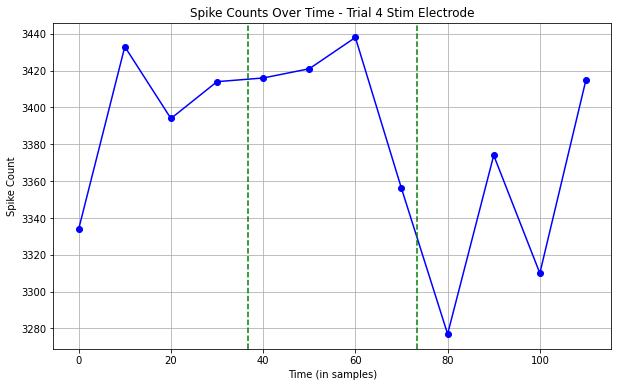

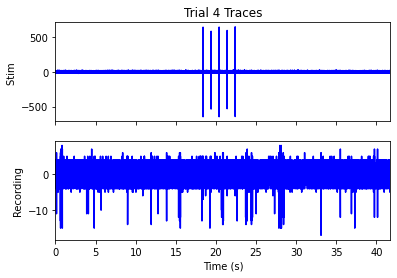

In [15]:
fp = '/mnt/disk15tb/nathaniel/Clean Stim N2/000233/data.raw.h5'
n2_t1_data = StimulationAnalysis(fp, recording_electrode=13306, stim_electrode=11766)
print(f'Stim Channel: {n2_t1_data.stim_channel}')
print(f'Recording Channel: {n2_t1_data.rec_channel}')
#print(n2_t1_data.get_spike_counts())
n2_t1_data.plot_stim_traces(4, bp_filter=True, time_range=0.1, start_at=18.38)
n2_t1_data.plot_stim_traces(4, bp_filter=True, time_range=0.1, start_at=18.2)
full_analysis(fp, 4, recording_electrode=13306, stim_electrode=11766)

# Dirty Method N2

Stim Channel: 901
Recording Channel: 862


            Time Range  Channel 862  Channel 901
0          0 to 100000            0         3341
1     100000 to 200000            0         3473
2     200000 to 300000            0         3369
3     300000 to 400000            0         3334
4     400000 to 500000            0         3353
5     500000 to 600000            0         3404
6     600000 to 700000            0         3582
7     700000 to 800000            0         3660
8     800000 to 900000            0         3531
9    900000 to 1000000            0         3549
10  1000000 to 1100000            0         3671
11  1100000 to 1200000            0         3640
12  1200000 to 1300000            0         3436
13  1300000 to 1400000            0         3331
14  1400000 to 1500000            0         3411
15  1500000 to 1600000            0         3356
16  1600000 to 1700000            0         3290
17  1700000 to 1800000            0         3361


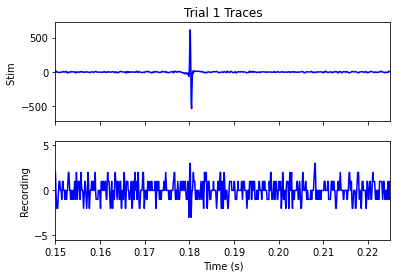

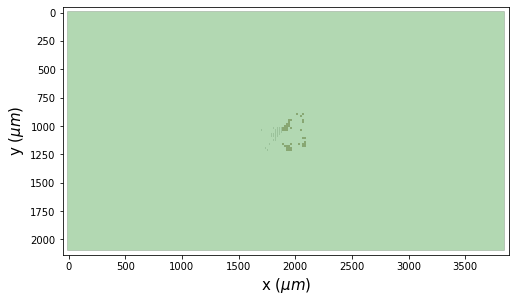

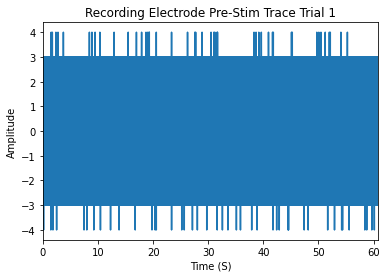

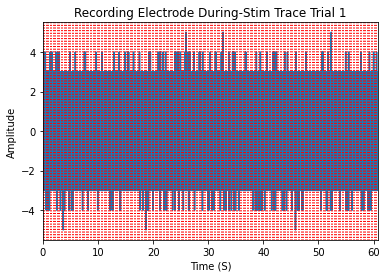

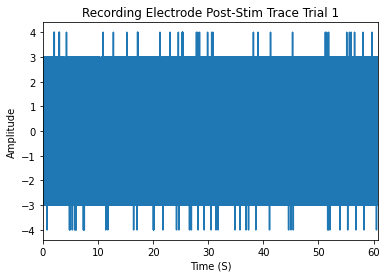

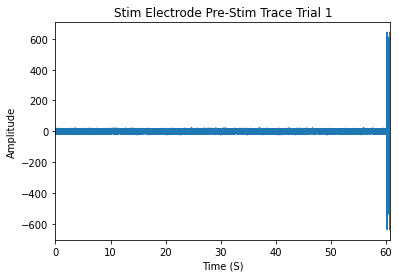

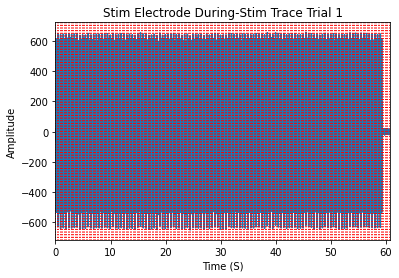

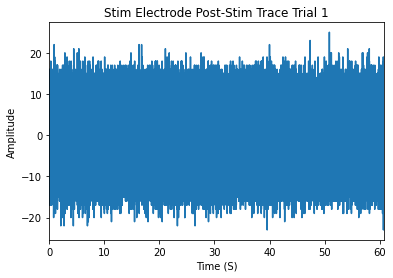

Pre-stim total spike count: 0
Stim total spike count: 0
Post-stim spike count: 0


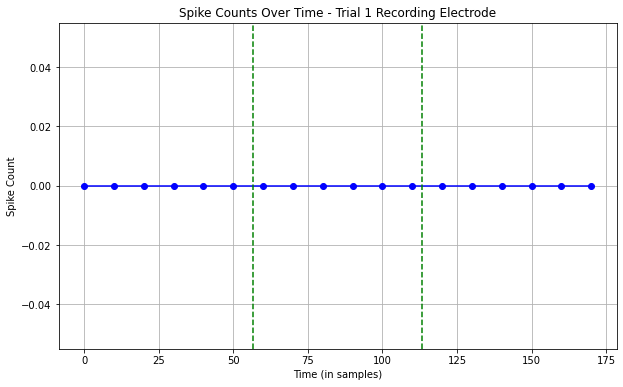

Pre-stim total spike count: 20274
Stim total spike count: 21633
Post-stim spike count: 20185


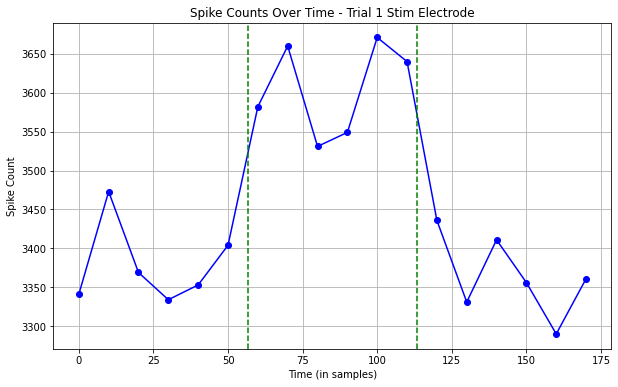

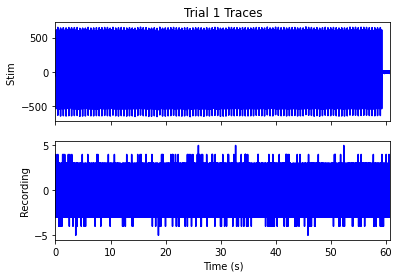

In [8]:
fp = '/mnt/disk15tb/nathaniel/Unclean Stim N2/000236/data.raw.h5'
n2_t1_data = StimulationAnalysis(fp, recording_electrode=13077, stim_electrode=13525)
print(f'Stim Channel: {n2_t1_data.stim_channel}')
print(f'Recording Channel: {n2_t1_data.rec_channel}')
print(n2_t1_data.get_spike_counts())
n2_t1_data.plot_stim_traces(1, bp_filter=True, time_range=0.075, start_at=0.15)
full_analysis(fp, 1, recording_electrode=13077, stim_electrode=13525)